<a href="https://colab.research.google.com/github/Only-Mike/DeepLearning-and-AI/blob/main/Group%20Assigment2/Assignment_2_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torchvision.transforms import ToTensor

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# Hyper-parameters of the model
num_epochs = 10
batch_size = 128
learning_rate = 0.003

In [17]:
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

**Loading** **data**

In [18]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

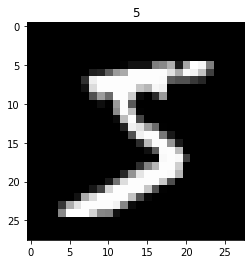

In [19]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

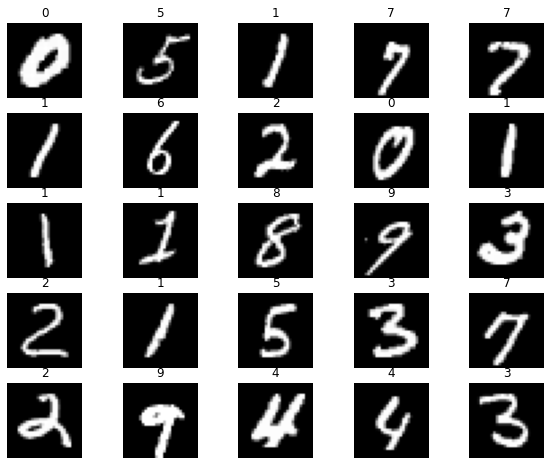

In [20]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [21]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [22]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [23]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True,num_workers=1)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=True,num_workers=1)

classes = ("0",'1', '2', '3', '4', '5', '6', '7', '8', '9')

In [24]:
print(train_data.data.size())


torch.Size([60000, 28, 28])


In [25]:
# implement conv net

#torch.nn.Conv2d(in_channels, out_channels, kernel_size)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5) #1 channel because our input is a grayscale image
        self.pool = nn.MaxPool2d(2,2) #size 2X2, stride: 2
        self.conv2 = nn.Conv2d(16, 28, 5)
        self.fc1 = nn.Linear(28*5*5, 120) #16*5*5= number of output channels * dimension of the output layer after feature learning; 120 manually set as outcome of the 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #the output dimension (in our case 10) needs to be equal to the number of classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) #torch.view() function freshape the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = ConvNet().to(device)

In [26]:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss already includes SoftMax
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [27]:
cnn = ConvNet()
print(cnn)

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 28, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=700, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Parameters

in_channels (int) — Number of channels in the input image

out_channels (int) — Number of channels produced by the convolution

kernel_size (int or tuple) — Size of the convolving kernel

stride (int or tuple, optional) — Stride of the convolution.
 Default 1

padding (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0

padding_mode (string, optional) — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’

dilation (int or tuple, optional) — Spacing between kernel elements. Default: 1

groups (int, optional) — Number of blocked connections from input channels to output channels. Default: 1

bias (bool, optional) — If True, adds a learnable bias to the output. Default: True

In [28]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [128, 1, 28, 28]
        # input_layer: 1 input channel, 16 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)
        
        # Backward and optimize
        optimizer.zero_grad() #with zero_grad() we ensure that the gradients are properly reset to zero at the start of each iteration
        loss.backward()
        optimizer.step()
        #wandb.log({"loss": loss})  uncomment this line if you want to send data to weights and biases interface


        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            # Calculate average accuracy for every 100 steps
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = correct / total
                #wandb.log({"accuracy": accuracy}) uncomment this line if you want to send data to weights and biases interface
        
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

RuntimeError: ignored